# Predicting patient outcomes after a given treatment time using the calculated probability with time curves

It will be useful for our models to calculate a predicted mRS outcome for a patient. The method detailed here uses only the patient's known mRS before stroke, the given time from onset to treatment, and the calculated probability with time curves (e.g. as calculated in the mathematics notebook). In other words, this method does not directly take into account any other factor relating to the patient, for example their age or whether they have had a stroke previously. 

## Aims

We want to compare a patient 'x' with the known cumulative probability distributions from before. We can draw graphs of changing probability with time, then overlay a horizontal line at our chosen point 'x'. We can then find which mRS bin patient 'x' is in at any arbitrary time. 

We will also implement ways to automatically determine which mRS bin contains the patient rather than depending on a human to read a graph.

## Generalisation
This notebook is condensed into a single function named `stroke_outcome()` [here](#Generalisation).

---
## Notebook admin

In [1]:
# Keep notebook cleaner once finalised
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set up MatPlotLib
%matplotlib inline
# Change default colour scheme:
plt.style.use('seaborn-colorblind')

---

## Initial setup - import data, define constants, and plot

### Import the probability data

In this example, we will use the data for an LVO treated with thrombectomy at times $t=0$ and $t=t_\mathrm{ne}$. Import the probability bins from file:

In [4]:
from outcome_utilities.mRS_datasets import (
    dict_t0_treatment_lvo_ect,  dict_no_treatment_lvo_ect )

In [5]:
mrs_prob_bins_t0_treatment = dict_t0_treatment_lvo_ect['bins']
mrs_prob_dist_t0_treatment = dict_t0_treatment_lvo_ect['dist']

mrs_prob_bins_no_treatment = dict_no_treatment_lvo_ect['bins']
mrs_prob_dist_no_treatment = dict_no_treatment_lvo_ect['dist']

Define the no-effect time for thrombectomy:

In [6]:
t_ne = 8 * 60 # minutes

### Define the constants $a$, $b$, and $A$

We will need the constants a, b, and A to calculate the changing probabilities with time. We can find these constants from the probability bins imported above by using `find_mrs_constants()`, a function that uses the same calculations as in the mathematics notebook.

In [7]:
from outcome_utilities.probs_with_time import find_mrs_constants

In [8]:
find_mrs_constants??

Signature:
find_mrs_constants(
    mrs_prob_bins_t0_treatment,
    mrs_prob_bins_no_treatment,
    t_ne,
)
Source:   
def find_mrs_constants(mrs_prob_bins_t0_treatment, 
    mrs_prob_bins_no_treatment, t_ne):
    """
    Find constants a,b,A for calculating probability with time.

    Inputs:
    mrs_prob_bins_t0_treatment - list or np.array. Cumulative probability 
                                 bins at t=0.
    mrs_prob_bins_no_treatment - list or np.array. Cumulative probability 
                                 bins at the no-effect time.
    t_ne                       - int or float. The no-effect time.

    Returns:
    a, b, A - arrays of five values, one for each mRS<=0,1,2,3,4. 
              See the mathematics notebook for usage.
    """
    # Use the [:-1] slice to exclude mRS<=5.
    G_t0  = np.log(      mrs_prob_bins_t0_treatment[:-1])
    B_t0  = np.log(1.0 - mrs_prob_bins_t0_treatment[:-1])
    G_tne = np.log(      mrs_prob_bins_no_treatment[:-1])
    B_tne = np.log(1

In [9]:
a, b, A = find_mrs_constants(mrs_prob_bins_t0_treatment, 
                             mrs_prob_bins_no_treatment, t_ne)

Each of these arrays contains five values, one for each mRS<=0,1,2,3,4. 

In [10]:
a

array([2.92153649, 2.50547806, 2.08799477, 2.25100113, 2.35247623])

In [11]:
b

array([-0.00608653, -0.00521975, -0.00434999, -0.00468959, -0.00490099])

In [12]:
A

array([0.19892614, 0.84026081, 1.36510562, 2.36703744, 3.96339452])

### Define a function to plot the probability bins

Previously we have plotted the cumulative probability lines, for example those calculated in the mathematics notebook. Here it will be clearer to colour the spaces in between the lines so that the image can be viewed as a series of stacked bins. We'll do this in a function named `plot_probs_filled()`.

Plot probability over a time range $t$:

In [13]:
t = np.arange(0,t_ne)

In [14]:
def plot_probs_filled(A,b,t):
    # P(mRS<=5)=1.0 at all times, so it has no defined A, a, and b.
    # Instead append to this array a 0.0, which won't be used directly
    # but will allow the "for" loop to go round one extra time.
    A = np.append(A,0.0)

    for i,A_i in enumerate(A):

        # Define the probability line, p_i:
        if i<5:
            p_i = 1.0/(1.0 + np.exp(-A_i -b[i]*t)) 
        else:
            # P(mRS<=5)=1.0 at all times:
            p_i = np.full(t.shape,1.0)
            
        # Plot it as before and store the colour used:
        l, = plt.plot(t, p_i, '-')#, label = f'mRS <= {i}')
        colour = l.get_color()

        # Fill the area between p_i and the line below, p_j.
        # This area marks where mRS <= the given value.
        # If p_j is not defined yet (i=0), set all p_j to zero:
        p_j = p_j if i>0 else np.zeros_like(p_i)
        plt.fill_between(t, p_i, p_j, label=f'mRS = {i}',
                         color=colour, alpha=0.3 )
        # ^ alpha is used as a quick way to lighten the fill colour.

        # Store the most recently-created line for the next loop:
        p_j = p_i


    plt.legend(loc='center left', bbox_to_anchor=[1.0,0.5,0.2,0.2])
    plt.ylabel('Probability')
    plt.xlabel('Onset to treatment time (mins)')
    plt.ylim(-0.02,1.02)

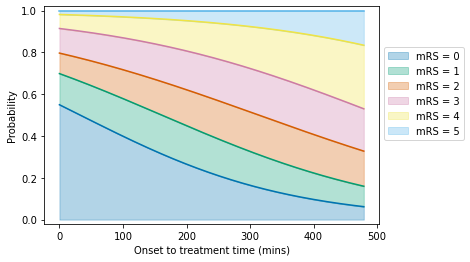

In [15]:
plot_probs_filled(A,b,t)
plt.show()

---

## Predicting mRS at a given time

We can estimate the change in mRS for a patient 'x' by using the probability distributions. As a simple method, we can pick a probability of our liking at time zero, and draw a straight horizontal line across to the no-effect time. This horizontal line shows the patient's changing mRS score with increasing treatment time. We can then pick out a particular treatment time and compare the predicted mRS then with the mRS had the patient reached the no-effect time without treatment. 

For example, we'll define an 'x' and treatment time:

In [16]:
x = 0.75
treatment_time = 210 # minutes

Plot which mRS bin this x value lands in at the treatment time:

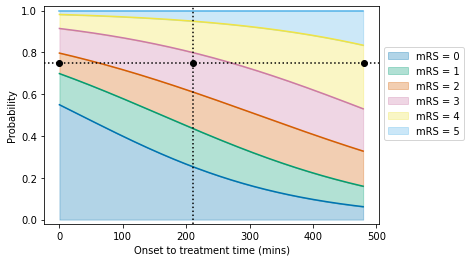

In [17]:
# Draw the filled bins as before:
plot_probs_filled(A,b,t)

# Draw vertical line:
plt.axvline(treatment_time, color='k', linestyle=':')
    
# Draw horizontal line:
plt.axhline(x, color='k', linestyle=':')
    
# Add scatter markers along the horizontal line at the three key times:
for v in [0,treatment_time,t_ne]:
    plt.scatter(v,x,color='k',marker='o')
    
plt.show()

For this example patient, the mRS changes from 2 at the start time to 4 at the no-effect time. By looking at where the horizontal and vertical lines meet, we can see that being treated at this example treatment time would result in an mRS of 3 - an increase of one point on the scale compared with no treatment.

To automatically find which mRS bin patient x will fall into at the selected treatment time, we need to know the bins at this time. To find this, we'll import the function `find_mrs_bins_t()` from our `outcome_utilities` module.

In [18]:
from outcome_utilities.probs_with_time import find_mrs_bins_t

In [19]:
find_mrs_bins_t??

Signature: find_mrs_bins_t(A, b, treatment_time)
Source:   
def find_mrs_bins_t(A, b, treatment_time):
    """
    Find the cumulative probability bins at a given time. 

    Inputs:
    A,b            - list or np.array. Contain constants for 
                     calculating probability.
    treatment_time - int or float. Time from onset to treatment. 

    Returns:
    mrs_prob_bins_t_treatment - np.array. Cumulative probabilities
                                of the mRS bins at the treatment time.
    """
    mrs_prob_bins_t_treatment = []
    for i,A_i in enumerate(A):
        p_i = 1.0/(1.0 + np.exp(-A_i -b[i]*treatment_time)) 
        mrs_prob_bins_t_treatment.append(p_i)

    return np.array(mrs_prob_bins_t_treatment)
File:      ~/stroke_outcome/outcome_utilities/probs_with_time.py
Type:      function


In [20]:
mrs_prob_bins_t_treatment = find_mrs_bins_t(A,b,treatment_time)

mrs_prob_bins_t_treatment

array([0.25364872, 0.43637533, 0.61102146, 0.79934802, 0.94951074])

To find out which of these bins our patient 'x' falls into, we use the `digitize()` function:

In [21]:
mRS_t0 = np.digitize(x, mrs_prob_bins_t0_treatment, right=True)
mRS_t  = np.digitize(x, mrs_prob_bins_t_treatment,  right=True)
mRS_no = np.digitize(x, mrs_prob_bins_no_treatment, right=True)

print(f'mRS pre-stroke:             {mRS_t0}')
print(f'mRS if not treated:         {mRS_no}')
print(f'mRS if treated at time={treatment_time}: {mRS_t}')

mRS pre-stroke:             2
mRS if not treated:         4
mRS if treated at time=210: 3


---

## Multiple patients

The same process can be performed for a larger sample of $x$ values at a fixed treatment time to calculate the percentage of patients who should see an improvement in mRS compared with receiving no treatment. 

First we'll consider only 4 patients at the same treatment time as before and check each improvement individually.

In [22]:
xs = np.arange(0.2,1.0,0.2)

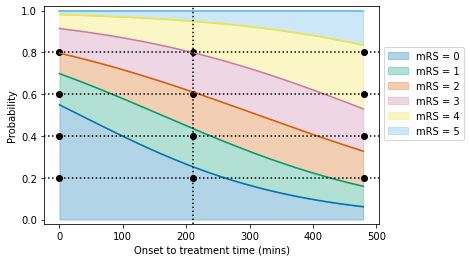

In [23]:
# Draw the filled bins as before:
plot_probs_filled(A,b,t)

# Draw vertical line:
plt.axvline(treatment_time, color='k', linestyle=':')
    
for x in xs:
    # Draw horizontal line:
    plt.axhline(x, color='k', linestyle=':')
    
    # Add scatter markers along the horizontal line at the three key times:
    for v in [0,treatment_time,t_ne]:
        plt.scatter(v,x,color='k',marker='o')
    
plt.show()

Some of these points are too close to the border between mRS bins for us to determine mRS by eye. This is where the `digitize()` method is most useful:

In [24]:
mRS_vals_t0_treatment = []
mRS_vals_t_treatment  = []
mRS_vals_no_treatment = []

for x in xs: 
    # Find which bin 'x' lies in,
    # i.e. which plotted probability line it lies under,
    # at time t=0, t=treatment_time, and t=T_0.
    mRS_t0_treatment = np.digitize(x, mrs_prob_bins_t0_treatment, right=True)
    mRS_t_treatment  = np.digitize(x, mrs_prob_bins_t_treatment,  right=True)
    mRS_no_treatment = np.digitize(x, mrs_prob_bins_no_treatment, right=True)
    
    # Store these in the lists:
    mRS_vals_t0_treatment.append(mRS_t0_treatment)
    mRS_vals_t_treatment.append( mRS_t_treatment)
    mRS_vals_no_treatment.append(mRS_no_treatment)

Print the results so that each column shows the changing mRS of one patient.

In [25]:
print(f'mRS pre-stroke:             {mRS_vals_t0_treatment}')
print(f'mRS if not treated:         {mRS_vals_no_treatment}')
print(f'mRS if treated at time={treatment_time}: {mRS_vals_t_treatment}')

mRS pre-stroke:             [0, 0, 1, 3]
mRS if not treated:         [2, 3, 4, 4]
mRS if treated at time=210: [0, 1, 2, 4]


For each of the patients, record whether their mRS improved compared with their untreated mRS level. If improved, record a 1, otherwise record a 0.

In [26]:
mRS_improved = []
for i, mRS_t_treatment in enumerate(mRS_vals_t_treatment):
    mRS_change = mRS_vals_no_treatment[i] - mRS_t_treatment
    if mRS_change >= 1:
        mRS_improved.append(1)
    else:
        mRS_improved.append(0)
        
mRS_improved

[1, 1, 1, 0]

Then take the average of the 1s and 0s across all patients. 

In [27]:
treatment_effect = np.mean(mRS_improved)

print(f'Probability of mRS improving by 1 or more: {treatment_effect}')

Probability of mRS improving by 1 or more: 0.75


For this patient population, three out of four patients saw an improvement in mRS when treated at the given treatment time. This matches the changes in mRS that we can read off the plot.

---

## Generalisation

To find a better estimate of the effectiveness of this treatment, we need to do the same calculation with a much higher number of patients. We'll sample random values of x for 100 patients and rewrite the code from before into one cell.

In [28]:
def stroke_outcome(mrs_prob_bins_t0_treatment, mrs_prob_bins_no_treatment, 
                   treatment_time, no_effect_time=8*60, 
                   xs=[], number_of_patients=100, print_result=1):
    """
    Inputs
    
    dist_0:           1D list or numpy array. Element i corresponds to 
                      the proportion of patients that had mRS=i, before stroke or 
                      if treated at time t=0.
    dist_F:           1D list or numpy array. Element i corresponds to 
                      the proportion of patients that had mRS=i if not treated
                      or treated after time_zero_effect
    treatment_time:   int. time in minutes between stroke and treatment    
    time_zero_effect: int. time in minutes after stroke that treatment
                      has no effect.                      
    single:           bool. If True, model will only perform one iteration    
    n_iter:           int. If single=False, number of iterations the model 
                      will perform.
    xs:               1D list or numpy array. List of values of 'x' to try.
                      
    
    Outputs
    
    mRS_0:  1D list. mRS if treated at time t=0     
    mRS_F:  1D list. mRS if treated at time_zero_effect  
    mRS_T:  1D list. mRS if treated at treatment_time
    """
    ### Step 1: Find a, b, and A
    a, b, A = find_mrs_constants(mrs_prob_bins_t0_treatment, 
                                 mrs_prob_bins_no_treatment, no_effect_time)

    ### Step 2: Find probability bins at treatment_time
    mrs_prob_bins_t_treatment = find_mrs_bins_t(A,b,treatment_time)

    ### Step 3: Find the mRS of patient x at the key times

    # Values of x to try:
    if len(xs)>0:
        number_of_patients = len(xs)
    else:
        # Generate random patients:
        xs = np.random.rand(number_of_patients)

    # Find mRS for each patient x:
    mRS_vals_t0_treatment = []
    mRS_vals_t_treatment  = []
    mRS_vals_no_treatment = [] 

    count=0
    while count<number_of_patients:
        x = xs[count]

        # Find which bin 'x' lies in at the three key times:
        mRS_vals_t0_treatment.append(
            np.digitize(x, mrs_prob_bins_t0_treatment, right=True))
        mRS_vals_t_treatment.append( 
            np.digitize(x, mrs_prob_bins_t_treatment,  right=True))
        mRS_vals_no_treatment.append(
            np.digitize(x, mrs_prob_bins_no_treatment, right=True))

        count += 1


    ### Step 4: Find the probability of improvement

    # For all of the patients (n_iter values of 'x'), record whether their 
    # mRS improved compared with their untreated mRS level. 
    # Then take the average of the 1s and 0s across all patients. 
    treatment_effect = np.mean(
        [1 if mRS_vals_no_treatment[i] - T >=1 else 0 
         for i,T in enumerate(mRS_vals_t_treatment)] )


    ### Print some useful things:
    if print_result>0:
        if len(xs)==1:
            print(f'mRS pre-stroke:            ',
                  f'{mRS_vals_t0_treatment[-1]}')
            print(f'mRS if not treated:        ',
                  f'{mRS_vals_no_treatment[-1]}')
            print(f'mRS if treated at time={treatment_time}:',
                  f'{mRS_vals_t_treatment[-1]}')
        else:
            print(f'Probability of mRS improving by 1 or more: ',
                  f'{treatment_effect}')

    return (mRS_vals_t0_treatment, mRS_vals_no_treatment, 
            mRS_vals_t_treatment, treatment_effect)

### Test the function

We'll use this function here in a couple of test cases.

__Test 1:__ Using the same single patient x at the same time as before should print the same values of mRS as we found earlier.

In [29]:
x = 0.75
treatment_time = 210 # minutes

In [30]:
(mRS_vals_t0_treatment, mRS_vals_no_treatment, 
 mRS_vals_t_treatment, treatment_effect) = (
    stroke_outcome(mrs_prob_bins_t0_treatment, mrs_prob_bins_no_treatment, 
                   treatment_time, no_effect_time=t_ne, xs=[x]))

mRS pre-stroke:             2
mRS if not treated:         4
mRS if treated at time=210: 3


These numbers match the single patient from earlier in the notebook.

__Test 2:__ We can also test 100 patients with randomly-generated x:

In [31]:
(mRS_vals_t0_treatment, mRS_vals_no_treatment, 
 mRS_vals_t_treatment, treatment_effect) = (
    stroke_outcome(mrs_prob_bins_t0_treatment, mrs_prob_bins_no_treatment, 
                   treatment_time, no_effect_time=t_ne, number_of_patients=100))

Probability of mRS improving by 1 or more:  0.78


This will give a different result each time depending on the patient population.

---

### __Example 1:__ Predicting mRS for groups of patients

By running the function multiple times, we can compare the average change in mRS at a range of different treatment times for different groups of 100 patients:

In [32]:
treatment_times = np.random.randint(0, t_ne, size=100)

print(np.mean(treatment_times), np.std(treatment_times))

230.67 127.6318968753501


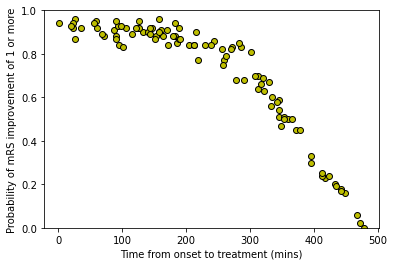

In [33]:
for treatment_time in treatment_times:
    (mRS_vals_t0_treatment, mRS_vals_no_treatment, 
     mRS_vals_t_treatment, treatment_effect) = (
    stroke_outcome(mrs_prob_bins_t0_treatment, mrs_prob_bins_no_treatment, 
                   treatment_time, no_effect_time=t_ne, 
                   number_of_patients=100, print_result=0))
    plt.scatter(treatment_time, treatment_effect, color='y', edgecolor='k')
    
plt.xlabel('Time from onset to treatment (mins)')
plt.ylabel('Probability of mRS improvement of 1 or more')
plt.ylim(0,1)
plt.show()

Two points at almost the same treatment time can have probabilities around 0.2 apart depending on the groups of patients considered. 

---

### __Example 2:__ Only know starting mRS, not precise 'x'

Sometimes we want to consider a patient of a known starting mRS, without randomly assigning them an 'x' value to test. Instead we can look at the full range of 'x' that covers that starting mRS. Here we'll plot the area of the graph we're interested in, and then find the possible values of mRS when a patient in that area is treated at a given time. 

We'll use a starting mRS of 1 at a treatment time of 210 minutes.

First, generate probabilities xs that give a t=0 mRS of m_start:

In [34]:
m_start = 1 
xmin = mrs_prob_bins_t0_treatment[m_start-1] # set xmin to 0 for mRS=0.
xmax = mrs_prob_bins_t0_treatment[m_start]

In [35]:
treatment_time = 210 

In [36]:
mrs_prob_bins_t_treatment = find_mrs_bins_t(A,b,treatment_time)

Plot the considered mRS as a probability range on the y-axis:

In [37]:
t = np.arange(0,t_ne)

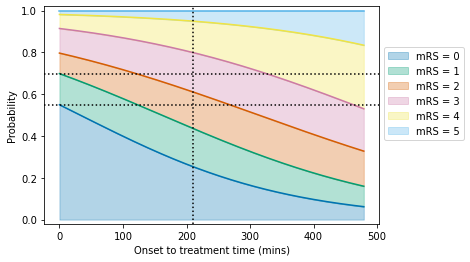

In [38]:
# Similar plot to before:
plot_probs_filled(A,b,t)

# Vertical line at treatment time:
plt.axvline(treatment_time, color='k', linestyle=':')
# Horizontal lines for considered 'x' range:
for x in [xmin,xmax]:
    plt.axhline(x, color='k', linestyle=':')
    
plt.show()

We can see that the group of 'x' values with mRS=1 at time t=0 will be predicted different mRS values at the chosen treatment_time. Some of the group will have mRS=2 and others mRS=3. To find the proportions of the group that will receive each prediction, we can use the following function.

In [39]:
def prob_mRS_in_xrange(bins,xmin,xmax,m_start='?',time='???'):
    """
    Given some range in cumulative probability, find the probability of being
    in each mRS bin at a given time t. 
    
    Inputs:
    bins    - List or np.array. List of cumulative probabilities of each mRS 
              at a given time t. 
    xmin    - Float. Minimum P(mRS<=x|t) to check.
    xmax    - Float. Maximum P(mRS<=x|t) to check
    m_start - String. Used for printing only, the mRS at t=0.
    time    - String. Used for printing only, the value of t.
    
    Returns:
    -
    """
    # Find intersections of the probability lines with the vertical t line
    # within the specified range of x:
    m_int = np.where( (bins<xmax) & (bins>xmin) )[0] 
    
    if len(m_int)>0:
        # Find the probability of each m:
        p_int = bins[m_int]
        
        # Include the boundary values at xmin, xmax:
        m_ints = np.array([m_int[0]-1, *m_int, m_int[-1]+1])+1
        p_ints = [xmin, *p_int, xmax]
        
        # Store probabilities here:
        pm_list = []
        for i in range(len(m_ints)-1):
            # Find the proportion of the probability range (y-axis span)
            # that is covered by this value of mRS.
            pmin = p_ints[i]
            pmax = p_ints[i+1]
            p_m = (pmax-pmin)/(xmax-xmin)
            print(f'P(mRS={m_ints[i]:1} | m_start={m_start:1},',
                  f't={time:3}): {p_m:1.4f}')
            pm_list.append(p_m)
        print('Sanity check: sum of probs', np.sum(pm_list))
        
    else:
        # If there are no intersections in the chosen x range,
        # find the fixed value of mRS in this range.
        try:
            m_int = np.where(bins>=xmax)[0][0]
        except:
            # m>4 isn't included in the input data.
            m_int = 5
        
        print(f'P(mRS={m_int:1} | m_start={m_start:1},',
              f't={time:3}): 1.0')
        m_ints  = [m_int]
        pm_list = [1.0]
        
    return m_ints, pm_list

Draw the plot again and then print the predicted mRS values:

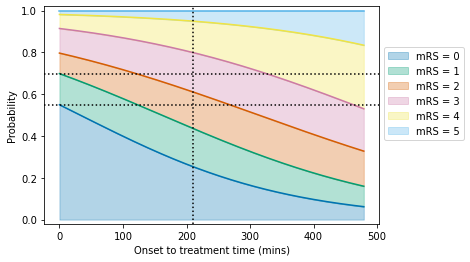

m_start: 1

Time = 0
P(mRS=1 | m_start=1, t=  0): 1.0

Time = 210
P(mRS=2 | m_start=1, t=210): 0.4126
P(mRS=3 | m_start=1, t=210): 0.5874
Sanity check: sum of probs 1.0

Time = 480
P(mRS=4 | m_start=1, t=480): 1.0


In [40]:
# Similar plot to before:
plot_probs_filled(A,b,t)

# Vertical line at treatment time:
plt.axvline(treatment_time, color='k', linestyle=':')
# Horizontal lines for considered 'x' range:
for x in [xmin,xmax]:
    plt.axhline(x, color='k', linestyle=':')
    
plt.show()

# Use this function to find the probability of each mRS at a given time:
print('m_start:', m_start)
# Check probability of each mRS at t=0, t=T, and t=T_0:
print('\nTime =', 0)
mRS_vals_t0_treatment, probs_t0_treatment = prob_mRS_in_xrange(
    mrs_prob_bins_t0_treatment, xmin, xmax, m_start, 0)

print('\nTime =', treatment_time)
mRS_vals_t_treatment, probs_t_treatment = prob_mRS_in_xrange(
    mrs_prob_bins_t_treatment, xmin, xmax, m_start, treatment_time)

print('\nTime =', t_ne)
mRS_vals_no_treatment, probs_no_treatment = prob_mRS_in_xrange(
    mrs_prob_bins_no_treatment, xmin, xmax, m_start, t_ne)

---